0 - Initializing and imporing data

In [41]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

In [16]:
dataset_path = '/kaggle/input/ais-dataset'

print(os.listdir(dataset_path))

['ais_data.csv']


In [21]:
df = pd.read_csv(os.path.join(dataset_path, 'ais_data.csv'))
# display(df.head())
df.columns

Index(['Unnamed: 0', 'mmsi', 'navigationalstatus', 'sog', 'cog', 'heading',
       'shiptype', 'width', 'length', 'draught'],
      dtype='object')

In [26]:
# If needed: load data (assuming CSV). If df is already provided, skip this.
# df = pd.read_csv('ais_dataset.csv')

# Rename columns for consistency (adjust names to your dataset)
df = df.rename(columns={'navigationalstatus':'Status', 'sog':'Speed', 'shiptype':'Type'})

# Convert Speed to numeric (knots); coerce errors to NaN
df['Speed'] = pd.to_numeric(df['Speed'], errors='coerce')

# Drop records missing status, speed, or type
df = df.dropna(subset=['Status', 'Speed', 'Type']).copy()

# (Optional) Normalize status text (e.g. lowercase)
df['Status'] = df['Status'].str.strip().str.lower()



,Unnamed: 0,mmsi,Status,Speed,cog,heading,Type,width,length,draught
0,0,219019621,unknown value,0.0,86.0,86.0,Fishing,4.0,9.0,NaN
1,1,265628170,unknown value,0.0,334.5,NaN,Port tender,8.0,27.0,NaN
2,2,219005719,unknown value,0.0,208.7,NaN,Fishing,4.0,11.0,NaN
3,3,219028066,unknown value,0.0,NaN,NaN,Pleasure,3.0,12.0,NaN
4,4,212584000,moored,0.0,153.0,106.0,Cargo,13.0,99.0,6.3
...,...,...,...,...,...,...,...,...,...,...
358346,387577,236125000,under way using engine,11.0,171.9,169.0,Cargo,12.0,82.0,4.2
358347,387578,209717000,under way using engine,16.6,341.6,343.0,Cargo,27.0,170.0,8.9
358348,387579,257182000,under way using engine,20.6,340.7,341.0,Passenger,36.0,224.0,6.9
358349,387580,219007697,unknown value,34.9,96.2,NaN,Pilot,3.0,7.0,NaN


1 - Data Pre processing

In [50]:
# jsut for get unique types of ships and status
# print("Statuses:", df['Status'].unique())
# print("Ship types:", df['Type'].unique())

df.columns

Index(['Unnamed: 0', 'mmsi', 'Status', 'Speed', 'cog', 'heading', 'Type',
       'width', 'length', 'draught', 'Speed_99', 'UnusualSpeed', 'IF_anomaly'],
      dtype='object')

2 - Data Exploring

In [32]:
# Basic stats
print(df['Speed'].describe())
# Group by ship type
print(df.groupby('Type')['Speed'].agg(['mean','std','max']))

count    357893.000000
mean         12.122554
std           9.355851
min           0.000000
25%           9.200000
50%          11.300000
75%          13.300000
max         214.000000
Name: Speed, dtype: float64
                       mean        std    max
Type                                         
Cargo             11.534036   3.137693   85.7
Dredging           8.297377   3.385377   26.8
Fishing            7.251214   4.944692  102.2
HSC               28.256253  10.545490   53.5
Law enforcement   15.724467   6.696543   45.5
Military          12.035392   5.340642   39.1
Passenger         14.869408   4.582909   79.7
Pilot             15.863421   6.973840  214.0
Pleasure           7.742045  14.232617  102.2
Port tender        6.313462  10.264058   54.3
Reserved          18.885662  30.424365  102.0
SAR               69.411845  43.990028  186.0
Sailing            2.701021   5.652675  102.2
Tanker            11.698053   2.256524   19.7
Towing             6.294391   2.505778   12.0
Towing

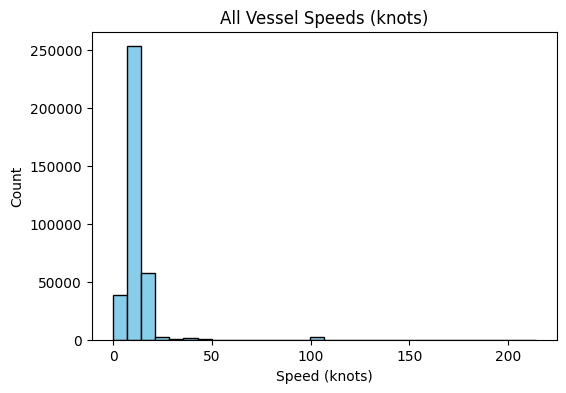

In [34]:
plt.figure(figsize=(6,4))
plt.hist(df['Speed'], bins=30, color='skyblue', edgecolor='black')
plt.title("All Vessel Speeds (knots)")
plt.xlabel("Speed (knots)"); plt.ylabel("Count")
plt.show()

3 - Rule-Based Anomaly Detection Anomaly dedection

3.1 - Vessels moving while Moored/Anchored

In [48]:
# Identify status labels for anchored/moored (adjust based on your data)
anchored_status = ['at anchor', 'anchored', 'moored']  # common labels

# Filter anomalies: these should not be moving, but speed > 0
anomaly_moving_at_anchor = df[df['Status'].isin(anchored_status) & (df['Speed'] > 0)]

print("Anomalies (moving while anchored/moored):", len(anomaly_moving_at_anchor))

anomaly_moving_at_anchor.head()


Anomalies (moving while anchored/moored): 2329


Index(['Unnamed: 0', 'mmsi', 'Status', 'Speed', 'cog', 'heading', 'Type',
       'width', 'length', 'draught', 'Speed_99', 'UnusualSpeed', 'IF_anomaly'],
      dtype='object')

3.2 - Vessels stopped while Under way

In [38]:
# Status labels for under way (add as needed)
underway_status = ['under way', 'under way using engine', 'under sail', 'under way - engine']

# Filter anomalies: should be moving, but speed == 0
anomaly_zero_speed = df[df['Status'].isin(underway_status) & (df['Speed'] == 0)]

print("Anomalies (stationary while under way):", len(anomaly_zero_speed))
anomaly_zero_speed.head()

Anomalies (stationary while under way): 205


,Unnamed: 0,mmsi,Status,Speed,cog,heading,Type,width,length,draught
201,201,370046000,under way using engine,0.0,335.3,79.0,Dredging,8.0,27.0,3.0
2095,2095,219171000,under way using engine,0.0,218.8,78.0,SAR,5.0,19.0,3.3
5184,5184,219007898,under way using engine,0.0,182.0,NaN,Cargo,7.0,36.0,2.7
5283,5283,219171000,under way using engine,0.0,237.1,78.0,SAR,5.0,19.0,3.3
5383,5383,370046000,under way using engine,0.0,301.3,78.0,Dredging,8.0,27.0,3.0


4 - Speed Anomalies

4.1 Statistical Threshold by Ship Type

In [40]:
# Compute 99th percentile of speed for each ship type
speed_thresholds = df.groupby('Type')['Speed'].quantile(0.99)

# Map each record to its type's threshold
df['Speed_99'] = df['Type'].map(speed_thresholds)

# Flag if speed exceeds threshold
df['UnusualSpeed'] = df['Speed'] > df['Speed_99']

# Extract anomalies
anomaly_speed = df[df['UnusualSpeed']]

print("Anomalies by speed threshold:", len(anomaly_speed))

anomaly_speed['Type'].value_counts().head()

Anomalies by speed threshold: 3356


,count
Type,
Cargo,1711
Tanker,785
Fishing,248
Passenger,159
Tug,100


4.2 Isolation Forest for Speed Outliers

In [43]:
# We'll use Speed (and optionally encode Type) as features.
# For simplicity, use speed alone here:
iso = IsolationForest(contamination=0.01, random_state=42)
df['IF_anomaly'] = iso.fit_predict(df[['Speed']])

# In scikit-learn, -1 means anomaly, 1 means normal.
anomaly_if = df[df['IF_anomaly'] == -1]
print("Anomalies by IsolationForest:", len(anomaly_if))

anomaly_if[['Speed', 'Type']].head()


Anomalies by IsolationForest: 3561


,Speed,Type
1396,48.1,Pleasure
1417,47.1,Pleasure
1438,44.3,Pleasure
1463,45.5,Pleasure
1476,46.7,Pleasure


5 - Finalize

In [44]:
print(f"Moved while anchored/moored: {len(anomaly_moving_at_anchor)}")
print(f"Stationary while under way:  {len(anomaly_zero_speed)}")
print(f"Speed-threshold outliers:    {len(anomaly_speed)}")
print(f"IsolationForest outliers:    {len(anomaly_if)}")


Moved while anchored/moored: 2329
Stationary while under way:  205
Speed-threshold outliers:    3356
IsolationForest outliers:    3561


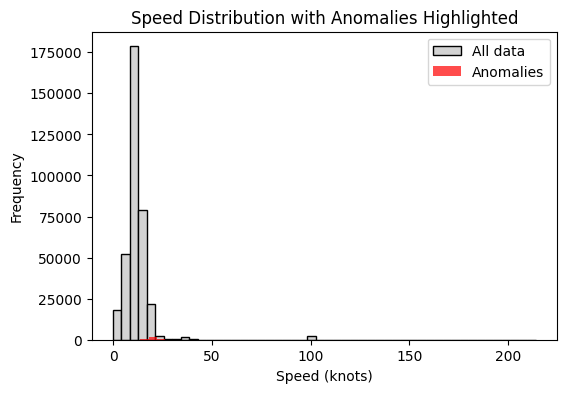

In [45]:
# Histogram of speeds, highlighting threshold-anomalies
plt.figure(figsize=(6,4))
plt.hist(df['Speed'], bins=50, color='lightgray', edgecolor='black', label='All data')
plt.hist(anomaly_speed['Speed'], bins=50, color='red', alpha=0.7, label='Anomalies')
plt.title("Speed Distribution with Anomalies Highlighted")
plt.xlabel("Speed (knots)"); plt.ylabel("Frequency")
plt.legend()
plt.show()
